In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load CSV files from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define file paths for training and testing datasets
train_file_path = '/content/drive/My Drive/IDS Dataset 2/NF-ToN-IoT-V2_15000 samples_minmax_normalized_train.csv'
test_file_path = '/content/drive/My Drive/IDS Dataset 2/NF-ToN-IoT-V2_15000 samples_minmax_normalized_test.csv'

# Load the datasets into DataFrames
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Separate features and labels for training and testing datasets
X_train = train_data.iloc[:, :-2]  # All columns except the last two (labels)
y_train = train_data.iloc[:, -1]    # Last column (label names)

X_test = test_data.iloc[:, :-2]     # All columns except the last two (labels)
y_test = test_data.iloc[:, -1]       # Last column (label names)

Mounted at /content/drive


Attack
Benign        3270
scanning      2722
xss           2235
ddos          1645
password       930
injection      601
dos            585
backdoor        13
mitm             5
ransomware       4
Name: count, dtype: int64


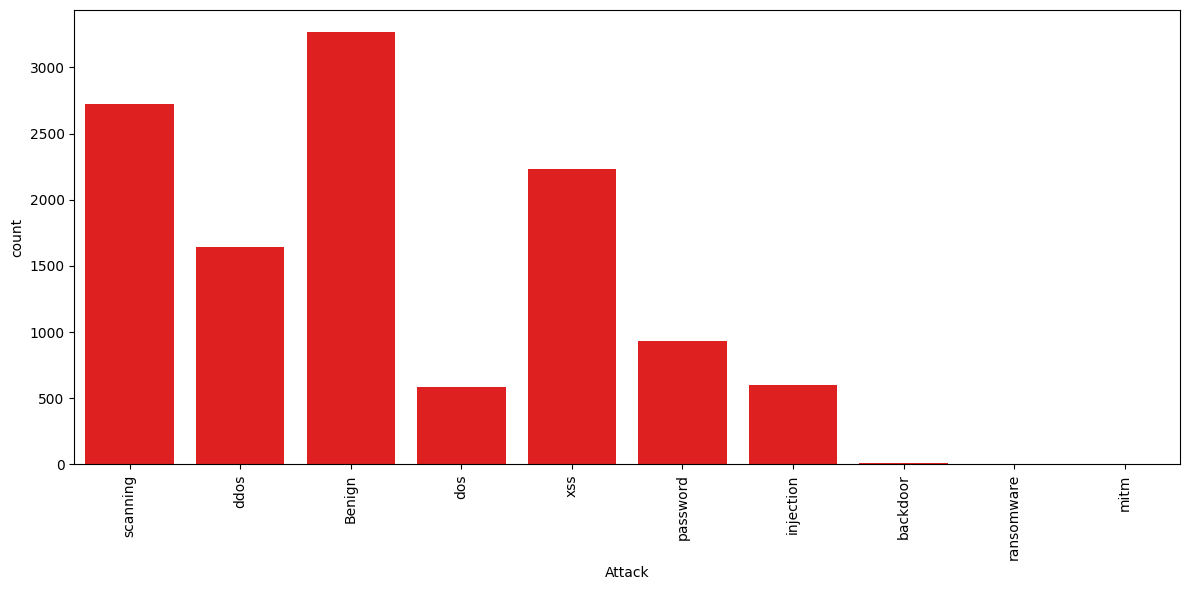

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

X = train_data.drop(['Attack'], axis=1)
y = train_data.loc[:, 'Attack']
print(train_data.loc[:, 'Attack'].value_counts())

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.countplot(data=train_data, x='Attack', color='red')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [3]:
X_train_nan_count = X_train.isna().sum().sum()
X_test_nan_count = X_test.isna().sum().sum()

print("Number of NaN values in X_train:", X_train_nan_count)
print("Number of NaN values in X_test:", X_test_nan_count)
print("Number of fearures:", X_train.shape[1])

Number of NaN values in X_train: 0
Number of NaN values in X_test: 0
Number of fearures: 41


In [4]:
from sklearn.model_selection import GridSearchCV

# Define the function for Grid Search Tuning
def GrdSrch_Tune(model, X, y, params):
    # Using recall as scoring for multiclass classification
    clf = GridSearchCV(model, params, scoring='recall_weighted', cv=5, n_jobs=-1)
    clf.fit(X, y)

    print("Best score is:", clf.best_score_)
    print("Best estimator is:", clf.best_estimator_)
    print("Best parameters are:", clf.best_params_)

    return clf.best_estimator_

In [5]:
params_DT = {
    'max_depth': [5, 10, 15],               # Limited max depth to prevent overfitting.
    'min_samples_split': [2, 5, 10],        # Keep the minimum samples for a split to prevent the tree from growing too large.
    'min_samples_leaf': [1, 2, 4],          # Ensure at least 1-4 samples in each leaf node to reduce overfitting.
    'max_features': ['sqrt', 'log2'],       # Use a subset of features at each split to reduce model complexity.
    'criterion': ['gini', 'entropy'],      # Gini and entropy are both good for measuring the quality of splits.
}
from sklearn.tree import DecisionTreeClassifier
GrdSrch_Tune(DecisionTreeClassifier(random_state = 42), X_train,y_train, params_DT )

Best score is: 0.9279766860949209
Best estimator is: DecisionTreeClassifier(max_depth=15, max_features='sqrt', min_samples_split=5,
                       random_state=42)
Best parameters are: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


DecisionTreeClassifier(max_depth=15, max_features='sqrt', min_samples_split=5,
                       random_state=42)

In [6]:
DT_Model = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_split=5, random_state=42)
DT_Model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_split=5, random_state=42)

In [7]:
y_pred_svc = DT_Model.predict(X_test)
y_pred_svc

array(['xss', 'scanning', 'xss', ..., 'scanning', 'scanning', 'Benign'],
      dtype=object)

In [8]:
#Compare actual y test V.S y_predict
df_rep_svc = pd.DataFrame({'actual data':y_test, 'predicted data':y_pred_svc})
df_rep_svc.head(10)

,actual data,predicted data
0,xss,xss
1,scanning,scanning
2,password,xss
3,password,password
4,scanning,scanning
5,Benign,Benign
6,Benign,Benign
7,password,password
8,scanning,scanning
9,Benign,Benign


In [9]:
# Import necessary libraries
import os
import joblib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path for the model and the folder name
model_folder = '/content/drive/My Drive/IDS models'
model_filename = 'NF-ToN-IoT-V2_Decision_Tree.pkl'
model_path = os.path.join(model_folder, model_filename)

# Create the folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Save the model to the specified path
joblib.dump(DT_Model, model_path)

print(f'Model saved successfully at: {model_path}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully at: /content/drive/My Drive/IDS models/NF-ToN-IoT-V2_Decision_Tree.pkl


In [10]:
#trained model is named DT_Model
y_pred = DT_Model.predict(X_test)

# Access the prediction for the 698th sample
print(f"Prediction for sample 698: {y_pred[698]} and the actual target is : {y_test[698]}")

Prediction for sample 698: Benign and the actual target is : Benign


In [11]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report

#classificatoin Report
rep = classification_report(y_test,y_pred)
print(rep)

#confusion Matrix
conf = confusion_matrix(y_test,y_pred)
print(conf)

              precision    recall  f1-score   support

      Benign       0.96      0.94      0.95       824
    backdoor       1.00      1.00      1.00         4
        ddos       0.93      0.97      0.95       390
         dos       0.89      0.88      0.89       156
   injection       0.69      0.67      0.68       125
        mitm       0.00      0.00      0.00         1
    password       0.90      0.83      0.86       219
  ransomware       0.00      0.00      0.00         1
    scanning       0.96      0.97      0.96       715
         xss       0.90      0.94      0.92       568

    accuracy                           0.93      3003
   macro avg       0.72      0.72      0.72      3003
weighted avg       0.93      0.93      0.93      3003

[[775   0   4   4   4   1   3   0  27   6]
 [  0   4   0   0   0   0   0   0   0   0]
 [  2   0 378   0   6   0   1   0   1   2]
 [  2   0   3 138   1   0   0   0   0  12]
 [  1   0  12   2  84   0   7   0   0  19]
 [  0   0   0   1   0   0 

Text(0.5, 1.0, 'Confusion Matrix')

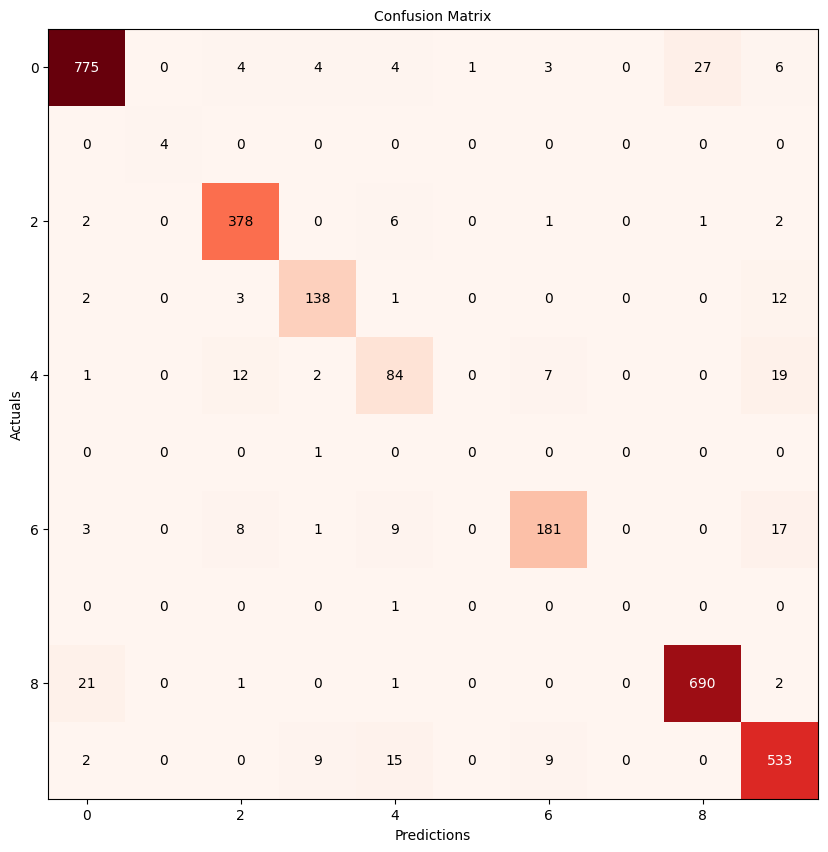

In [12]:
#mlxtend plot_confusion_matrix
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf,figsize=(10,10), cmap=plt.cm.Reds)

plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

In [13]:
from sklearn.model_selection import cross_val_score
scores_DT = cross_val_score(DT_Model, X_train, y_train ,cv = 10, scoring = 'recall_weighted')
avg_scores_DT = scores_DT.mean()
avg_scores_DT

0.9274771024146545

In [14]:
scores_DT_test = cross_val_score(DT_Model, X_test, y_test ,cv = 10, scoring = 'recall_weighted')
avg_scores_DT_test = scores_DT_test.mean()
avg_scores_DT_test

0.9024252491694351

In [15]:
print("Train score is:",format(avg_scores_DT))
print("Test score is:",format(avg_scores_DT_test))

Train score is: 0.9274771024146545
Test score is: 0.9024252491694351
